In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

AMD Ryzen 5 5600G 4.46GHz

Intel N100 

Text(0.5, 0, 'Generation')

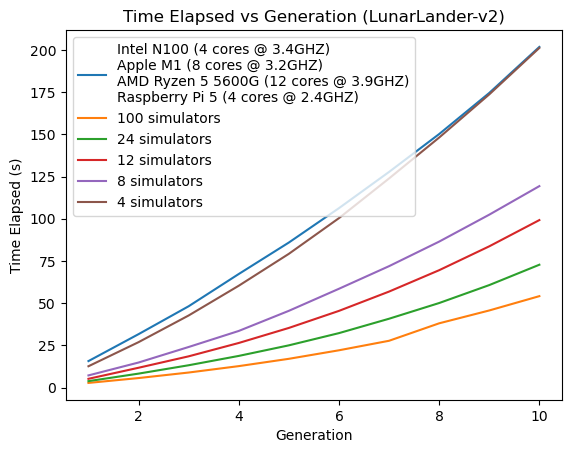

In [54]:
df_100 = pd.read_csv("lunar_lander_100_envs.csv")
df_24 = pd.read_csv("lunar_lander_24_envs.csv")
df_12 = pd.read_csv("lunar_lander_12_envs.csv")
df_8 = pd.read_csv("lunar_lander_8_envs.csv")
df_4 = pd.read_csv("lunar_lander_4_envs.csv")
df_all = pd.read_csv("lunar_lander_all_hosts.csv")
plt.plot(df_all['generation'], df_all['time_elapsed'], label='Intel N100 (4 cores @ 3.4GHZ)\nApple M1 (8 cores @ 3.2GHZ)\nAMD Ryzen 5 5600G (12 cores @ 3.9GHZ)\nRaspberry Pi 5 (4 cores @ 2.4GHZ)')
plt.plot(df_100['generation'], df_100['time_elapsed'], label='100 simulators')
plt.plot(df_24['generation'], df_24['time_elapsed'], label='24 simulators')
plt.plot(df_12['generation'], df_12['time_elapsed'], label='12 simulators')
plt.plot(df_8['generation'], df_8['time_elapsed'], label='8 simulators')
plt.plot(df_4['generation'], df_4['time_elapsed'], label='4 simulators')
plt.legend()
plt.title("Time Elapsed vs Generation (LunarLander-v2)")
plt.ylabel("Time Elapsed (s)")
plt.xlabel("Generation")

core            0     1     2     3     4   5   6   7   8   9   10  11
time_elapsed                                                          
0.000000      10.2   NaN   NaN   NaN   NaN NaN NaN NaN NaN NaN NaN NaN
0.000011       NaN  29.0   NaN   NaN   NaN NaN NaN NaN NaN NaN NaN NaN
0.000011       NaN   NaN  10.6   NaN   NaN NaN NaN NaN NaN NaN NaN NaN
0.000012       NaN   NaN   NaN  27.3   NaN NaN NaN NaN NaN NaN NaN NaN
0.000012       NaN   NaN   NaN   NaN  11.4 NaN NaN NaN NaN NaN NaN NaN


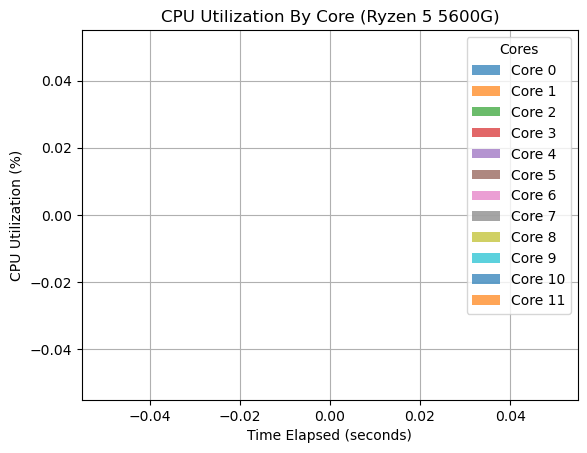

In [104]:
df = duckdb.query("""
SELECT * FROM db.public.cpu_utilization
WHERE worker = 'desktop'
""").df()

df['time_elapsed'] = df['time'] - df['time'].min()

# Pivot the DataFrame to get cores as columns
df_pivot = df.pivot_table(index='time_elapsed', columns='core', values='utilization')

print(df_pivot.head())

# Apply smoothing to the data
window_size = 2  # Number of points to average in moving average
df_smooth = df_pivot.rolling(window=window_size, center=False).mean()

# Plotting

# Generate the stacked area plot
plt.stackplot(df_smooth.index, 
              [df_smooth[col] for col in df_smooth.columns], 
              labels=[f'Core {col}' for col in df_smooth.columns], 
              alpha=0.7)

plt.xlabel('Time Elapsed (seconds)')
plt.ylabel('CPU Utilization (%)')
plt.title('CPU Utilization By Core (Ryzen 5 5600G)')
plt.legend(title='Cores')
plt.grid(True)
plt.show()

    


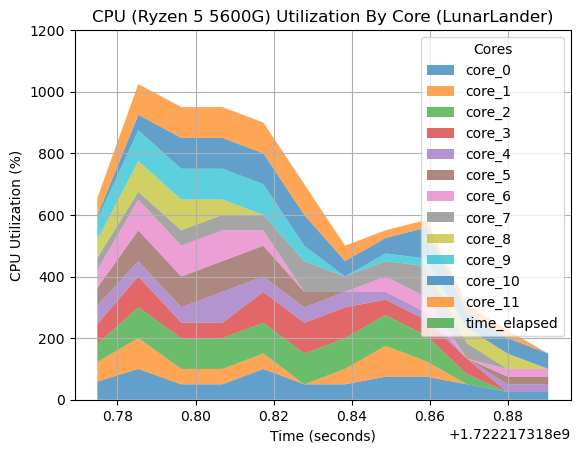

In [80]:
# Load the CSV file into a DataFrame
df = pd.read_csv('benchmarking/cpu_utilization.csv')

df['time_elapsed'] = df['time'] - df['time'].min()

# Apply smoothing to the data
window_size = 2  # Number of points to average in moving average
df_smooth = df.copy()

# Apply moving average to each core's data
for column in df.columns[1:]:  # Skip the 'time' column
    df_smooth[column] = df[column].rolling(window=window_size, center=False).mean()

plt.ylim(0, 1200)

# Generate the stacked area plot
plt.stackplot(df_smooth['time'], 
              [df_smooth[column] for column in df_smooth.columns[1:]], 
              labels=df_smooth.columns[1:], 
              alpha=0.7)

plt.xlabel('Time (seconds)')
plt.ylabel('CPU Utilization (%)')
plt.title('CPU (Ryzen 5 5600G) Utilization By Core (LunarLander)')
plt.legend(title='Cores')
plt.grid(True)
plt.show()



In [64]:
ip = "192.168.4.203"
duckdb.sql("INSTALL postgres;")
duckdb.sql("LOAD postgres;")
duckdb.sql(f"ATTACH 'dbname=postgres user=postgres host={ip} password=template!PWD' AS db (TYPE POSTGRES);")


BinderException: Binder Error: Failed to attach database: database with name "db" already exists

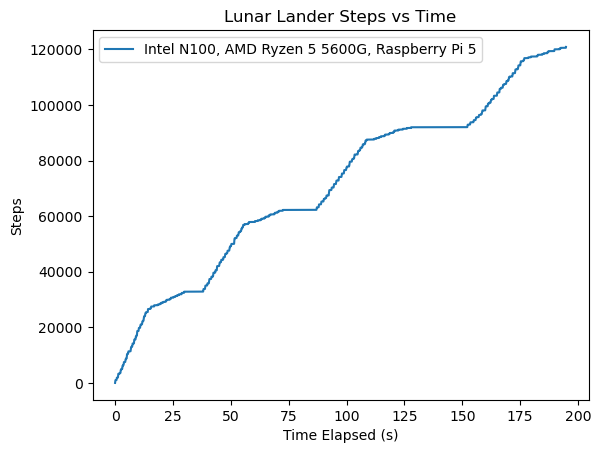

In [82]:
df = duckdb.query("""
SELECT time, COUNT(*) OVER (ORDER BY time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as num_steps
FROM db.public.training
ORDER BY time
""").df()

df['elapsed_time'] = df['time'] - df['time'].min()

plt.plot(df['elapsed_time'], df['num_steps'], label='Intel N100, AMD Ryzen 5 5600G, Raspberry Pi 5')

plt.ylabel('Steps')
plt.xlabel('Time Elapsed (s)')
plt.title("Lunar Lander Steps vs Time")
plt.legend()

Text(0.5, 1.0, 'Lunar Lander')

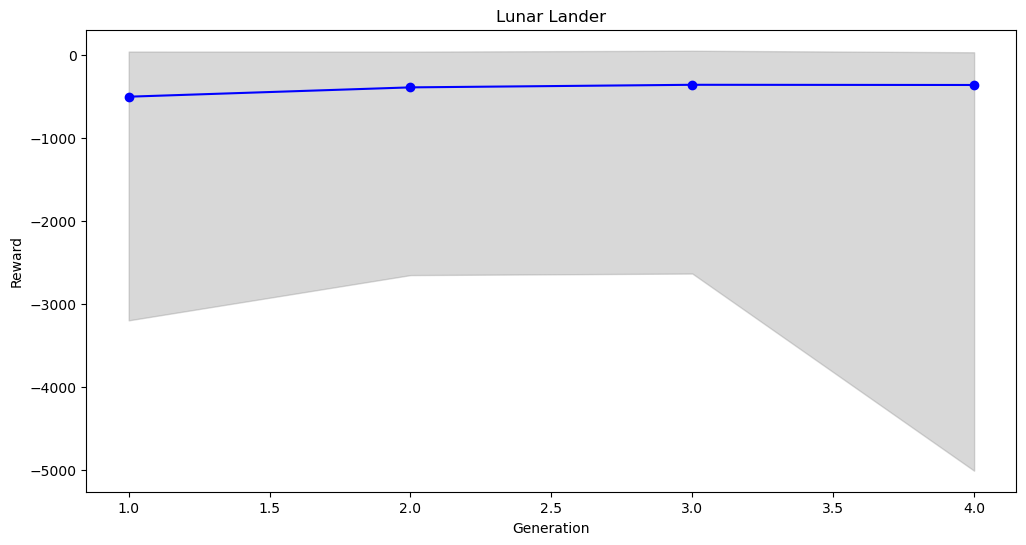

In [84]:
import matplotlib.pyplot as plt
import duckdb

# Query to get the data
df = duckdb.query("""
WITH cumulative_reward AS
(
    SELECT generation, SUM(reward) AS cumulative_reward
    FROM db.public.training
    GROUP BY generation, team_id
)
SELECT generation, 
       MIN(cumulative_reward) AS min_cumulative_reward, 
       AVG(cumulative_reward) AS avg_cumulative_reward, 
       MAX(cumulative_reward) AS max_cumulative_reward
FROM cumulative_reward
GROUP BY generation
ORDER BY generation
""").df()

# Plotting the data
plt.figure(figsize=(12, 6))  # Set figure size

# Plot shaded area for min and max
plt.fill_between(df['generation'], 
                 df['min_cumulative_reward'], 
                 df['max_cumulative_reward'], 
                 color='gray', alpha=0.3, label='Range (Min-Max)')

# Plot Average Cumulative Reward
plt.plot(df['generation'], df['avg_cumulative_reward'], 
         color='blue', label='Average Cumulative Reward', linestyle='-', marker='o')

# Add labels and title
plt.ylabel('Reward')
plt.xlabel('Generation')
plt.title("Lunar Lander")
